# Vaccination Simulation

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nafot
from tqdm import tqdm, tqdm_notebook
import networkx as nx
import matplotlib.dates
import pickle
%matplotlib inline

In [4]:
# gdf = nafot.gdf.copy()

## Loading the data

### Static contact network

In [3]:
# Read the network from gpickle
# network = nx.read_gpickle("../../Data/network/static_network_100K.gpickle")
network = nx.read_gpickle("../../data/static_network_with_age_100K.gpickle")

KeyboardInterrupt: 

Remove nodes without connections

In [ ]:
thresh = 0
nodes_to_remove = []
for n in network.nodes:
    if network.degree[n] <= thresh and network.nodes[n]['contacts'] > thresh:
        nodes_to_remove.append(n)

# Remove from the network
network.remove_nodes_from(nodes_to_remove)

# Network size
N = len(network.nodes)

Print network characteristics

In [ ]:
def calculate_number_of_contacts(network):
    total_contacts, total_remaning_contacts = 0,0
    for n in network.nodes:
        node = network.nodes[n]
        total_contacts += node['contacts']
        total_remaning_contacts += node['remaining_contacts']
    
    return total_contacts, total_remaning_contacts        

In [ ]:
print(f'Number of nodes: {network.number_of_nodes():,d}\n\
Number of edges {network.number_of_edges():,d}\n')

print(f'Theoretical contacts: {calculate_number_of_contacts(network)[0]:,d}\n\
Total remaining contacts: {calculate_number_of_contacts(network)[1]:,d}\n\
Existing contacts = Theoretical contacts - Total remaining contacts: {calculate_number_of_contacts(network)[0]-calculate_number_of_contacts(network)[1]:,d}\n\
Number of edges: {network.number_of_edges():,d} ; \
2*Number of edges: {2*network.number_of_edges():,d}')

### Contact matrices

In [9]:
# Loading the contact matrices
contact_matrix = pd.read_csv('../data/matrix/contact_matrix_final_sample.csv')
contact_matrix_yeshuv = pd.read_csv('../data/matrix/contact_matrix_final_sample_yeshuv.csv')
contact_matrix_subdist = pd.read_csv('../data/matrix/contact_matrix_final_sample_subdist.csv')

# Setting index, dtype and replacing nan with 0
# Stat area contact matrix
contact_matrix.set_index(contact_matrix.columns[0], inplace=True)
contact_matrix.columns = contact_matrix.columns.astype(int)
contact_matrix.fillna(0, inplace=True)
# Yeshuv contact matrix
contact_matrix_yeshuv.set_index(contact_matrix_yeshuv.columns[0], inplace=True)
contact_matrix_yeshuv.columns = contact_matrix_yeshuv.columns.astype(int)
contact_matrix_yeshuv.fillna(0, inplace=True)
# Subdist contact matrix
contact_matrix_subdist.set_index(contact_matrix_subdist.columns[0], inplace=True)
contact_matrix_subdist.columns = contact_matrix_subdist.columns.astype(float)
contact_matrix_subdist.fillna(0, inplace=True)

### Vaccination data

In [10]:
# Vaccination data
vaccination_data = pd.read_csv('../../Data/vaccination_data/vaccinated_patients.csv')
vaccination_data['vac_date'] = pd.to_datetime(vaccination_data['vac_date'])

# Remove incomplete seasons
vaccination_data = vaccination_data[~vaccination_data.vac_season.isin([2007,2018])].copy()

# Get a list of the dates of 2017 season
dates_2017 = [pd.Timestamp(2016,6,1) + pd.Timedelta(days=1)*i for i in range(365)]

# Short list of dates (1.9-28.2) and days in season
dates_2017_short = [pd.Timestamp(2016,9,1) + pd.Timedelta(days=1)*i for i in range(181)]
day_in_season_2017_short = [(date - pd.datetime(date.year if date.month>5 else date.year-1, 6, 1)).days for date in dates_2017_short]
# month_star_indices_short = [0, 30, 61, 91, 122, 153]

# Get only data from 2017 season
# vaccination_data_2017 = vaccination_data[vaccination_data.vac_season == 2017].copy()

### Stat_area-clinics data

Add clinic code for each node

In [11]:
# Read stat_area-clinics data 
stat_areas_clinics = pd.read_csv('../../Data/vaccination_data/stat_areas_with_clinics.csv')

# Load data populatin by clinic data
population_by_clinic = pd.read_csv('../../Data/vaccination_data/population_by_clinic.csv')
population_by_clinic.set_index('clinic_code', inplace=True)
population_by_clinic.columns = ['data_population']

# Get only relevant stat areas
stat_areas_clinics = stat_areas_clinics[stat_areas_clinics.stat_area_id.isin(contact_matrix.index)]
stat_areas_clinics.set_index('stat_area_id', inplace=True)

# Create a dictionary of stat area: clinic
stat_area_clinics_dict = {stat_area_id: stat_areas_clinics.loc[stat_area_id].clinic_code for stat_area_id in stat_areas_clinics.index}

# Creat a list of relevant clinics
relevant_clinics = stat_areas_clinics.clinic_code.unique()

# Get population data only data for relevant clinics
population_by_clinic = population_by_clinic.loc[relevant_clinics].copy()

# Initialize a dictionary for the network population by clinic
network_pop_by_clinic = dict.fromkeys(relevant_clinics, 0)

# Add the relevant clinic code for each node and update the population by clinic dictionary
for n in network.nodes:
    network.nodes[n]['clinic'] = stat_area_clinics_dict[network.nodes[n]['area']]
    network_pop_by_clinic[network.nodes[n]['clinic']] += 1

# And create a dictionary {node: clinic}
node_clinic = {node: network.nodes[node]['clinic'] for node in network.nodes()}

# Add to the population data frame
population_by_clinic['network_population'] = population_by_clinic.index.map(lambda clinic: network_pop_by_clinic[clinic])

# Calculate the factor between the real data and the network data
population_by_clinic['factor'] = population_by_clinic['network_population'] / population_by_clinic['data_population']

### Create data for the fit - average vaccination count

In [12]:
# Get relevant days - shifted by 1/alpha
alpha = 1/7
relevant_days = np.array(day_in_season_2017_short) + 1/alpha

# Get only relevant data (according to the short season definition)
vaccination_data_short_season = vaccination_data[vaccination_data.vac_day_of_season.isin(set(relevant_days))].copy()

# Group by day of season and claculate the mean number of vaccination per day
vaccination_data_avg = vaccination_data_short_season.groupby('vac_day_of_season').count()[['random_ID']] / 10

# Create a dictionary for vaccination count by clinic at each stage (day of the season)
vacc_avg_data_by_clinic_adj = dict.fromkeys(relevant_clinics, [0]*len(dates_2017_short))

# Go over the clinics
for clinic in relevant_clinics:
    # Get only data of current clinics
    cur_clinic_data = vaccination_data_short_season[vaccination_data_short_season.clinic_code == clinic]
    
    # Group by dates and count the number of vaccination at each day
    cur_clinic_avg_gb = cur_clinic_data.groupby('vac_day_of_season').count()[['random_ID']] / 10
    
    # Get current clinic vaccination average at each day (including 0 if no vaccination)
    cur_clinic_avg_vacc = np.array([cur_clinic_avg_gb.loc[day].random_ID if day in cur_clinic_avg_gb.index else 0 for day in relevant_days])
    
    # Normalize by populaion size
    cur_clinic_vac_avg_norm = cur_clinic_avg_vacc / population_by_clinic.loc[clinic].data_population
    
    # Multiply by the factor between the real and model data
    vacc_data_adj = cur_clinic_vac_avg_norm * population_by_clinic['factor'].loc[clinic]
    vacc_avg_data_by_clinic_adj[clinic] = vacc_data_adj

## Plot vaccination data

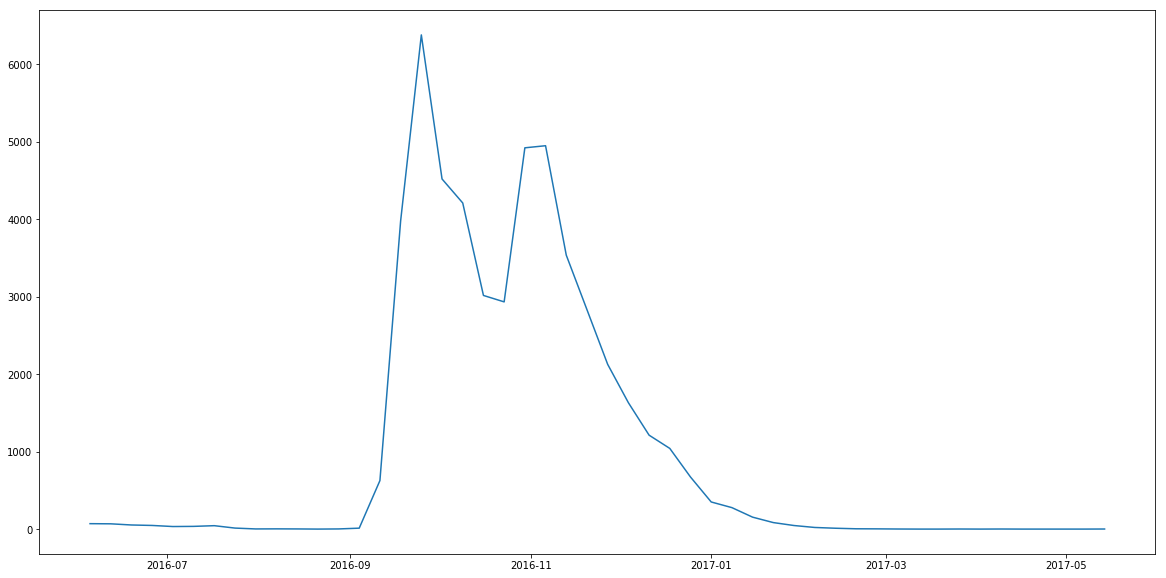

In [13]:
fig = plt.figure(figsize=(20, 10)) 

start_point = pd.Timestamp(2016,6,1) 
end_point = pd.Timestamp(2017,5,31)

# start_point = pd.Timestamp(2016,9,1) 
# end_point = pd.Timestamp(2017,2,28)


sample_vac_trendline_data = vaccination_data.copy()
# sample_vac_trendline_data['vac_date'] = pd.to_datetime(sample_vac_trendline_data['vac_date'])
sample_vac_trendline_data = sample_vac_trendline_data.groupby('vac_date').count()[['random_ID']]
    
vacc = sample_vac_trendline_data[start_point:end_point].resample('W').sum().fillna(0)
plt.plot(vacc)
plt.show()

### Plot aggregated data to fit - average vaccination count

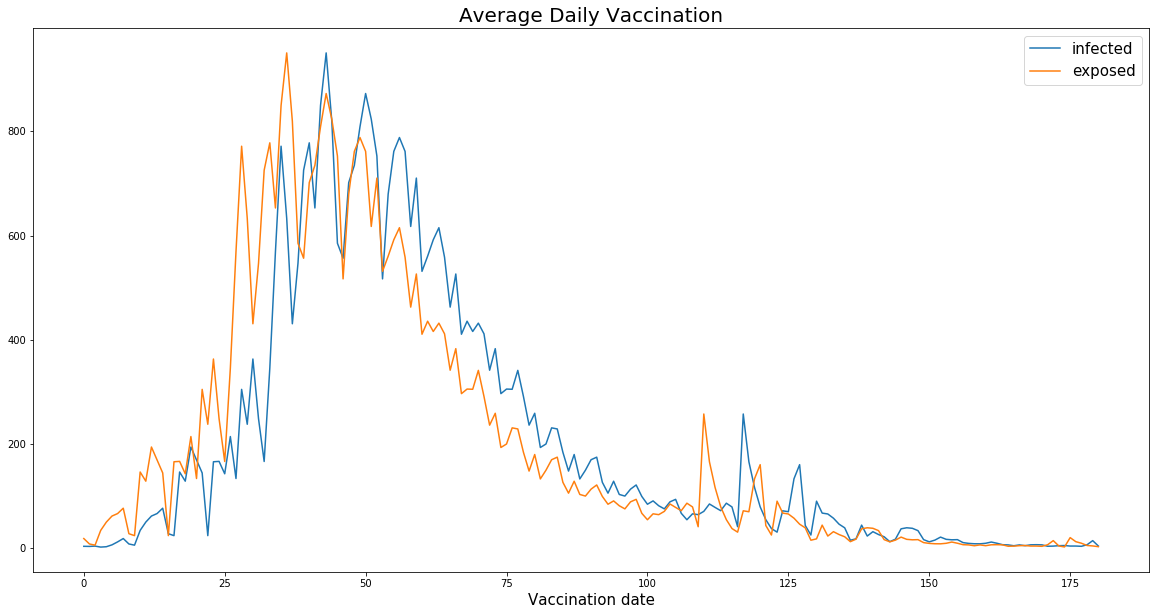

In [14]:
# Get only relevant data (according to the short season definition)
vaccination_data_short_season = vaccination_data[vaccination_data.vac_day_of_season.isin(day_in_season_2017_short)].copy()
vaccination_data_short_season_exposed = vaccination_data[vaccination_data.vac_day_of_season.isin(relevant_days)].copy()

# Group by day of season and claculate the mean number of vaccination per day
vaccination_data_avg = vaccination_data_short_season.groupby('vac_day_of_season').count()[['random_ID']] / 10
vaccination_data_avg_exposed = vaccination_data_short_season_exposed.groupby('vac_day_of_season').count()[['random_ID']] / 10

plt.figure(figsize=(20,10))
plt.plot(vaccination_data_avg.random_ID.values, label='infected')
plt.plot(vaccination_data_avg_exposed.random_ID.values, label='exposed')

# dates_ticks = [f'{date.day}/{date.month}' for date in np.array(relevant_days)[month_star_indices_short]]
# plt.xticks(np.array(day_in_season_2017_short), size=12)

plt.legend(fontsize=15)
plt.title('Average Daily Vaccination', size=20)
plt.xlabel('Vaccination date', size=15)
plt.show()

## The Model

### Model Parameters

In [15]:
# Random infection rate
beta_1 = 0.00015

# Friends infection rate
beta_2 = 0.02

# Transmission rate from E to I
alpha = 1/7

# Transmission rate from I to R
gamma = 1/7

In [16]:
# beta_1*len(S_0)*0.9

In [17]:
# (1/gamma)*beta_2*13

### Componenets

#### Initialization

In [18]:
# Infected - initialize 0.001 of the population - chose according to susceptibility score
I_0 = set(np.random.choice(list(network.nodes), replace=False, size=round(N*0.005)))

# Suseptible
S_0 = set(network.nodes) - I_0

# Exposed - initialize to empty set
E_0 = set()

# Recovered - initialize to empty set
R_0 = set()

# Initialize lists to save all the states
S = [S_0]
E = [E_0]
I = [I_0]
R = [R_0]

# Intialize a list to save the newly infected
new_I = [set()]

# Intialize a list to save the newly exposed
new_E = [set()]

# Initialize a dictionary lambdas_kt
lambdas = dict.fromkeys(relevant_clinics, np.array([0.]*len(dates_2017_short)))

#### Run

In [19]:
# for t in tqdm(range(len(dates_2017))):
for t in tqdm(range(len(dates_2017_short))):
    new_exposed_t = set()
    new_infected_t = set()
    new_recovered_t = set()
    
    #####################################
    ####--- Infection from friends ---###
    #####################################
    # Go over the infected individuals
    for node in I[-1]:
        for contact in network[node]:
            # If the contact is susceptible and not exposed in this stage yet 
            if contact in S[t-1] and contact not in new_exposed_t:
                # Contact is exposed with probability beta_2
                new_exposed_t.add(contact) if np.random.rand() < beta_2 else None
                # Update lambda_kt
                lambdas[node_clinic[node]][t] += beta_2


    ####################################
    ######--- Random Infection ---######
    ####################################
    # Go over the susceptible individuals
    for node in S[-1]:
        # If node was not exposed in this stage yet
        if node not in new_exposed_t:
            # Node is exposed with probability beta_1
            new_exposed_t.add(node) if np.random.rand() < beta_1 else None
            # Update lambda_kt
            lambdas[node_clinic[node]][t] += beta_1

            
    # Transmission from E to I 
    for node in E[-1]:
        # Individuals transmitted from E to I with probability alpha
        new_infected_t.add(node) if np.random.rand() < alpha else None
        
    # Transmission from I to R
    for node in I[-1]:
        # Individuals transmitted from I to R with probability gamma
        new_recovered_t.add(node) if np.random.rand() < gamma else None
        
    # Update stages
    S.append(S[-1] - new_exposed_t)
    E.append(E[-1].union(new_exposed_t) - new_infected_t)
    I.append(I[-1].union(new_infected_t) - new_recovered_t)
    R.append(R[-1].union(new_recovered_t))
    
    # Save the newly infected ad exposed
    new_I.append(new_infected_t)
    new_E.append(new_exposed_t)

100%|████████████████████████████████████████████████████████████████████████████████| 181/181 [00:37<00:00,  4.88it/s]


## Analysis

#### Get the newly infected and exposed by stage by clinic

In [20]:
# Initialize a dictionary to save the newly infected by clinic
new_I_by_clinic = dict.fromkeys(relevant_clinics, np.array([0]*(len(dates_2017_short)+1)))
new_E_by_clinic = dict.fromkeys(relevant_clinics, np.array([0]*(len(dates_2017_short)+1)))

# Go over the time stemps and count the newly infected by clinic
for t, new_I_t in enumerate(new_I):
    for node in new_I_t:
        new_I_by_clinic[network.nodes[node]['clinic']][t] += 1
        
# Go over the time stemps and count the newly exposed by clinic
for t, new_E_t in enumerate(new_E):
    for node in new_I_t:
        new_E_by_clinic[network.nodes[node]['clinic']][t] += 1

### Plot

Get final sizes

In [21]:
print(f'Population size: {N:,d}')
print(f'Number of Susceptible: {len(S[-1]):,d} ({(len(S[-1])/N)*100:.2f}%)')
print(f'Number of Exposed: {len(E[-1]):,d} ({(len(I[-1])/N)*100:.2f}%)')
print(f'Number of Infected: {len(I[-1]):,d} ({(len(E[-1])/N)*100:.2f}%)')
print(f'Number of Recovered: {len(R[-1]):,d} ({(len(R[-1])/N)*100:.2f}%)')
print(f'Total number of vaccinated individuals (I+R): {len(I[-1])+len(R[-1]):,d} ({((len(I[-1])+len(R[-1]))/N)*100:.2f}%)')

Population size: 99,062
Number of Susceptible: 40,487 (40.87%)
Number of Exposed: 59 (0.06%)
Number of Infected: 57 (0.06%)
Number of Recovered: 58,459 (59.01%)
Total number of vaccinated individuals (I+R): 58,516 (59.07%)


Get states sizes throughout stages

In [22]:
new_I_sizes = np.array([len(st) for st in new_I[1:]])
new_E_sizes = np.array([len(st) for st in new_E[1:]])

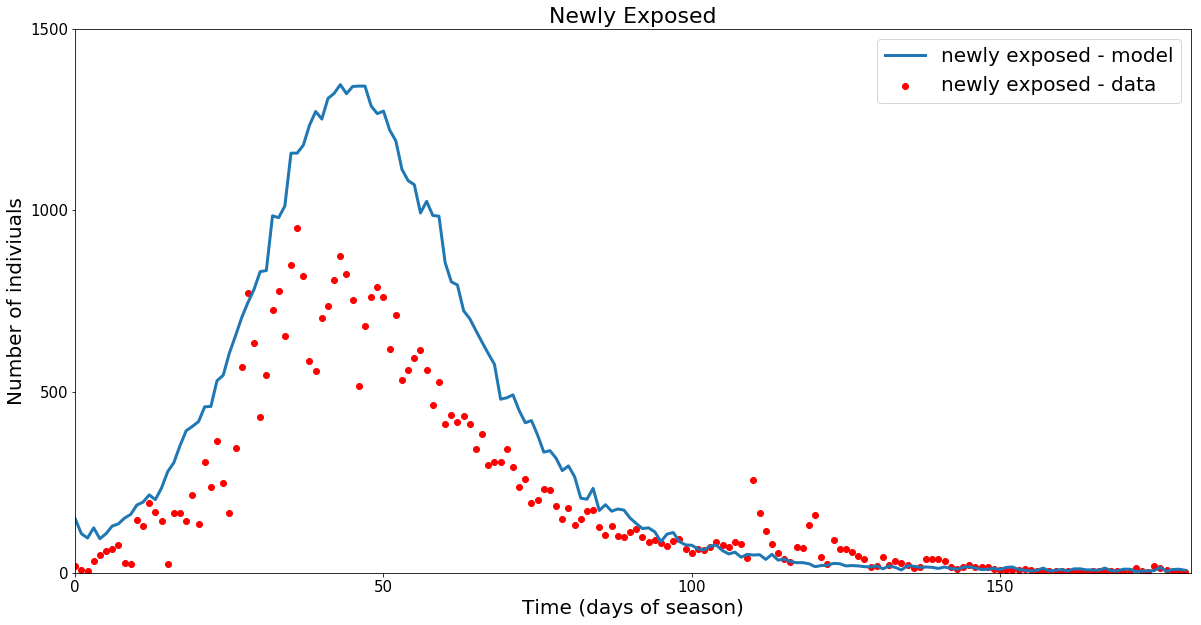

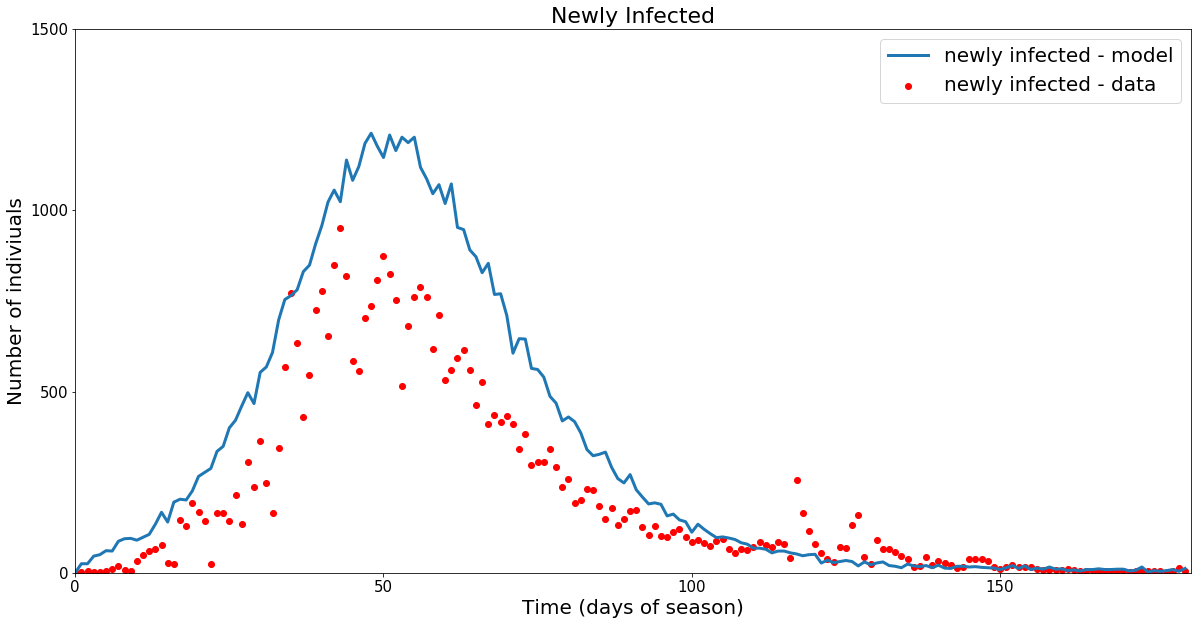

In [38]:
ts = np.arange(len(new_I_sizes))

# Newly exposed
plt.figure(figsize=(20,10))
plt.plot(ts, new_E_sizes, label='newly exposed - model', linewidth=3)
plt.scatter(ts, vaccination_data_avg_exposed.iloc[:,0].values, label='newly exposed - data', c='r')

plt.title('Newly Exposed', size=22)

plt.xlabel('Time (days of season)', size=20)
plt.ylabel('Number of indiviuals', size=20)

plt.xlim([0,len(dates_2017_short)])
plt.xticks(ts[::50], size=15)

# Set the y_lim (according the the highest point)
max_ = np.max([(max(new_E_sizes)) , max(vaccination_data_avg_exposed.iloc[:,0].values)]) 
lim = np.ceil(max_/500)*500
plt.ylim([0,lim])
plt.yticks(np.arange(0,lim+500,500), size=15)

plt.legend(fontsize=20)

plt.show()

print('\n\n')

# Newly infected
plt.figure(figsize=(20,10))
plt.plot(ts, new_I_sizes, label='newly infected - model', linewidth=3)
plt.scatter(ts, vaccination_data_avg.iloc[:,0].values, label='newly infected - data', c='r')

plt.title('Newly Infected', size=22)

plt.xlabel('Time (days of season)', size=20)
plt.ylabel('Number of indiviuals', size=20)

plt.xlim([0,len(dates_2017_short)])
plt.xticks(ts[::50], size=15)

# Set the y_lim (according the the highest point)
max_ = np.max([(max(new_I_sizes)) , max(vaccination_data_avg.iloc[:,0].values)]) 
lim = np.ceil(max_/500)*500
plt.ylim([0,lim])
plt.yticks(np.arange(0,lim+500,500), size=15)

plt.legend(fontsize=20)

plt.show()

In [25]:
S_sizes_norm = np.array([len(st)/N for st in S])
E_sizes_norm = np.array([len(st)/N for st in E])
I_sizes_norm = np.array([len(st)/N for st in I])
R_sizes_norm = np.array([len(st)/N for st in R])

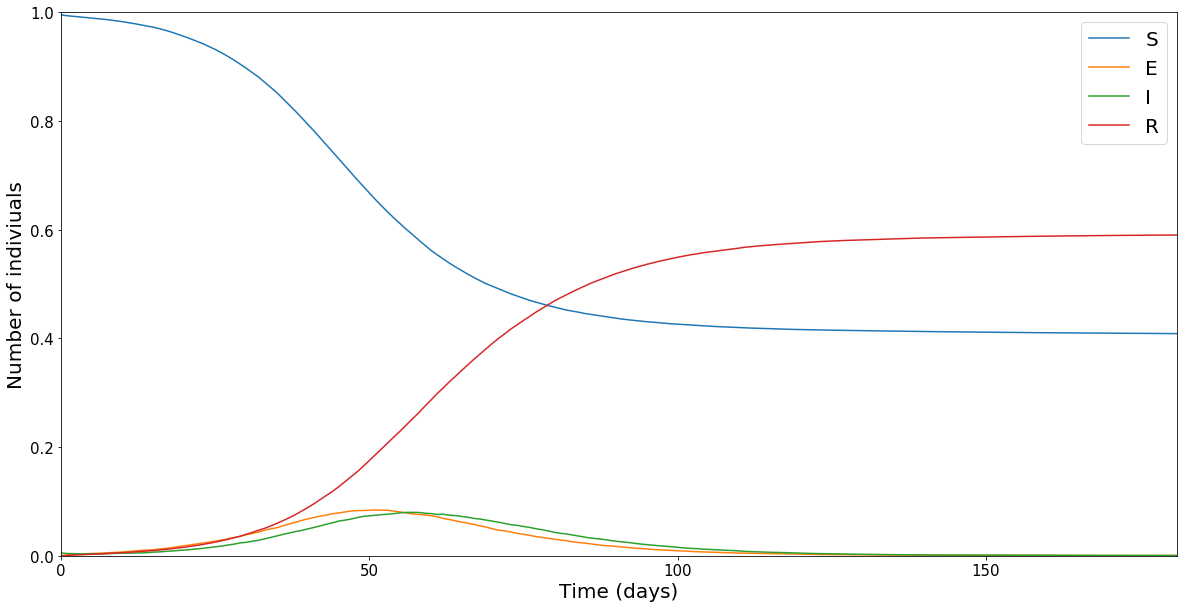

In [26]:
ts = np.arange(len(S))
plt.figure(figsize=(20,10))
plt.plot(ts, S_sizes_norm, label='S')
plt.plot(ts, E_sizes_norm, label='E')
plt.plot(ts, I_sizes_norm, label='I')
plt.plot(ts, R_sizes_norm, label='R')

# plt.title()

plt.xlabel('Time (days)', size=20)
plt.ylabel('Number of indiviuals', size=20)

plt.xlim([0,len(dates_2017_short)])
plt.xticks(ts[::50], size=15)

# plt.ylim([0,100000])
# plt.yticks(np.arange(0,120000,20000), size=15)
plt.ylim([0,1])
plt.yticks(np.arange(0,1.2,0.2), size=15)

plt.legend(fontsize=20, loc='upper right')
plt.show()

## Model Fit

### Calculate log-liklihood

In [27]:
def log_likelihood(lambdas, vacc_data_adj):
    # Initialize a variable to sum the log-likelihood
    res = 0
    
    # Go over the clinics
    for clinic in relevant_clinics:
        # Sum the log-likelihhod for each stage
        res += np.sum(-lambdas[clinic] + vacc_data_adj[clinic]*np.log(lambdas[clinic]))
        
    return res

In [28]:
for clinic, lambs in lambdas.items():
    if (lambs == 0).any():
        print (clinic)

In [29]:
log_likelihood(lambdas, vacc_avg_data_by_clinic_adj)

-4630728.939042724

# OLD

In [111]:
a = vaccination_data.vac_date[0] 
z = a - pd.datetime(a.year, 6, 1)
z.days

145

In [108]:
pd.datetime(a.year, 6, 1)

datetime.datetime(2007, 6, 1, 0, 0)

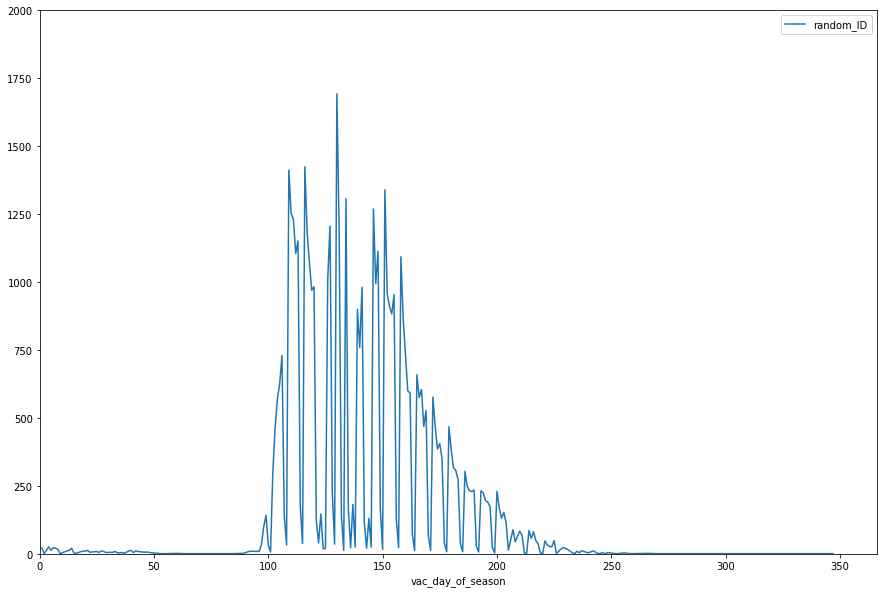

In [13]:
vaccination_data_2017.groupby('vac_day_of_season')[['random_ID']].count().plot(figsize=(15,10))
plt.xlim([0,366])
plt.ylim([0,2000])
plt.show()

In [9]:
vac_count_2017 = vaccination_data_2017.groupby('vac_day_of_season')[['vac_date']].count()
non_zeo_days = vac_count_2017.index.values

In [198]:
a = sample_vac_trendline_data_counter[start_point:end_point].reset_index(inplace=False)
a['day_of_week'] = a.vac_date.apply(lambda x: x.weekday_name)

In [199]:
a[a.day_of_week =='Friday']['random_ID'].sum()

1569

In [201]:
a[a.day_of_week =='Wednesday']['random_ID'].sum()

9091

In [197]:
c = sample_vac_trendline_data_counter[start_point:end_point].iloc[0].name
c.weekday_name

'Wednesday'

## Population by clinic

In [631]:
demg_data = pd.read_csv('../../Data/vaccination_data/sample_dem_data.txt')
demg_data.columns

Index(['Unnamed: 0', 'random_ID', 'registration_date', 'customer_situation',
       'birth_year', 'male/female', 'stat_code', 'stat_desc', 'doctors_ID',
       'doctors_random_ID', 'Lamas_socioeconomic_score',
       'Points_socioeconomic_score', 'Points_AGAS_code',
       'country_of_origin_code', 'country_of_origin_desc',
       'date_of_immigration'],
      dtype='object')

In [632]:
demg_data = pd.read_csv('../../Data/vaccination_data/sample_dem_data.txt')
demg_data.columns = ['Unnamed: 0', 'random_ID', 'registration_date', 'customer_situation',
       'birth_year', 'male/female', 'clinic_code', 'stat_desc', 'doctors_ID',
       'doctors_random_ID', 'Lamas_socioeconomic_score',
       'Points_socioeconomic_score', 'Points_AGAS_code',
       'country_of_origin_code', 'country_of_origin_desc',
       'date_of_immigration']
population_by_clinic = demg_data.groupby('clinic_code').count()[['random_ID']]
population_by_clinic.columns = ['population']
population_by_clinic.to_csv('../../Data/vaccination_data/population_by_clinic.csv')

In [625]:
population_by_clinic.head()

,population
stat_code,
1000,7
1106,2214
1107,1419
1108,606
1109,3844


## Old calculation

### Generating susceptibility score for each node

In [12]:
# Load vaccination probability data
vaccination_prob = pd.read_csv('../../data/vaccination_data/vaccination_proba_with_age_clinic.csv')

# Get vaccination probability data by clinic
vaccination_prob_by_clinic = {clinic: vaccination_prob[vaccination_prob.clinc_code == clinic].vacc_prob.values for clinic in relevant_clinics}
# vaccination_prob_by_clinic_and_age = {}

# Generate susceptibility values from the data and create susceptibility dictionary
susceptibility_dict = {n: np.random.choice(vaccination_prob_by_clinic[network.nodes[n]['clinic']], replace=True) for n in network.nodes}

# get a list of the normlized susceptibility (sums to 1)
susceptibility_norm = np.array(list(susceptibility_dict.values())) / np.sum(list(susceptibility_dict.values()))

### Create data for the fit - daily and weekly

In [13]:
# Create a dictionary for vaccination count by clinic at each stage (day of the season)
vacc_data_by_clinic_adj = dict.fromkeys(relevant_clinics, [0]*365)
vacc_data_by_clinic_adj_weekly = dict.fromkeys(relevant_clinics, [0]*365)

# Go over the clinics
for clinic in relevant_clinics:
    # Get only data of current clinics
    cur_clinic_data = vaccination_data_2017[vaccination_data_2017.clinic_code == clinic]
    
    # Group by dates and count the number of vaccination at each day
    cur_clinic_gb = cur_clinic_data.groupby('vac_date').count()[['random_ID']]
    
    # Get current clinic vaccination count at each day (including 0 if no vaccination)
    cur_clinic_vac_count = [cur_clinic_gb.loc[date].random_ID if date in cur_clinic_gb.index else 0 for date in dates_2017]
    
    # Normalize by populaion size
    cur_clinic_vac_count_norm = cur_clinic_vac_count / population_by_clinic.loc[clinic].data_population
    
    # Add dates
    clinic_vac_count_norm_by_date = pd.DataFrame(cur_clinic_vac_count_norm, index=dates_2017, columns=['vaccination_count'])
    
    # Multiply by the factor between the real and model data
    vacc_data_adj = clinic_vac_count_norm_by_date * population_by_clinic['factor'].loc[clinic]
    vacc_data_by_clinic_adj[clinic] = vacc_data_adj.vaccination_count.values
    
    # Resample (aggregate) weekly and save to the new_I_by_clinic dictionary
    vacc_data_by_clinic_adj_weekly[clinic] = vacc_data_adj.resample('W').sum().fillna(0).vaccination_count.values
    
# Save the data
# with open('../../Data/vaccination_data/vacc_data_by_clinic_adj.pickle','wb') as pickle_out:
#     pickle.dump(vacc_data_by_clinic_adj, pickle_out)
    
# with open('../../Data/vaccination_data/vacc_data_by_clinic_adj_weekly.pickle','wb') as pickle_out:
#     pickle.dump(vacc_data_by_clinic_adj_weekly, pickle_out)

# Loading the dict
# with open('../../Data/vaccination_data/vacc_data_by_clinic.pickle','wb') as pickle_in:
#     sparse_ares_dict = pickle.load(pickle_in)

In [37]:
def effective_size(S):
    """Recives S as a set of nodes an calculates the effctive size, i.e. the sum of the susceptibility of the nodes in S"""
    effective_size = 0
    for node in S:
        effective_size += susceptibility_dict[node]
    return effective_size

#### Get the newly infected by stage by clinic

In [249]:
# Initialize a dictionary to save the newly infected by clinic
new_I_by_clinic = dict.fromkeys(relevant_clinics, np.array([0]*(len(dates_2017_short)+1)))

# Go over the time stemps and count the newly infected by clinic
for t, new_I_t in enumerate(new_I):
    for node in new_I_t:
        new_I_by_clinic[network.nodes[node]['clinic']][t] += 1

#### Aggregate weekly

##### Newly infected by stage by clinic - aggregated weekly

In [438]:
# Initialize a dictionary to save the newly infected by clinic per week
new_I_by_clinic_weekly = dict.fromkeys(relevant_clinics, np.array([0]*53))

# Go over the daily infected data by clinic
for clinic, new_I_clinic in new_I_by_clinic.items():
    # Aggregate weekly
    new_I_clinic_df = pd.DataFrame(new_I_clinic[1:], index=dates_2017_short, columns=['newly_infected'])
    new_I_clinic_weekly = new_I_clinic_df.resample('W').sum().fillna(0).newly_infected.values
    # Save to the dict
    new_I_by_clinic_weekly[clinic] = new_I_clinic_weekly

##### S_eff_sizes - aggregated weekly

In [437]:
# S_eff_sizes_df = pd.DataFrame(S_eff_sizes[1:], index=dates_2017_short, columns=['S_eff_size'])
# S_eff_sizes_weekly = S_eff_sizes_df.resample('W').sum().fillna(0).S_eff_size.values

#### Calculate $\lambda_{kt}$ for each clinic and stage

In [439]:
# Initialize a dictionary lambdas_eff_it
lambdas_eff = dict.fromkeys(relevant_clinics)

for clinic in relevant_clinics:
    # Calculate lambda_it for eact t according to the formula
    cur_lambdas_eff = (new_I_by_clinic[clinic][1:]/population_by_clinic.network_population.loc[clinic]) / np.array(S_eff_sizes)[1:] # Daily
#     cur_lambdas_eff = (new_I_by_clinic_weekly[clinic]/population_by_clinic.network_population.loc[clinic]) / np.array(S_eff_sizes_weekly) # Weekly

    # Add to the dict
    lambdas_eff[clinic] = cur_lambdas_eff

In [ ]:
#                 new_exposed_t.add(contact) if np.random.rand() < beta_2*susceptibility_dict[contact] else None            
#             new_exposed_t.add(node) if np.random.rand() < beta_1*susceptibility_dict[node] else None


In [ ]:
# Infected - initialize 0.001 of the population - chose according to susceptibility score
I_0 = set(np.random.choice(list(network.nodes), replace=False, size=round(len(network.nodes)*0.005), p=susceptibility_norm))



# # Intialize a list to save effective sizes of S (sum of the susceptibilities)
# S_eff_sizes = [effective_size(S_0)]

#### Update $\lambda_{kt}$ for each clinic and stage

In [27]:
# Calculate the size of S_kt (for each clinic for each stage)
S_sizes_ = np.array([len(st)/N for st in S])

for clinic in relevant_clinics:
    # Add the random infection component
    lambdas[clinic] = lambdas[clinic] + beta_1*S_sizes[1:]

NameError: name 'S_sizes' is not defined

### Plot vaccination data by subdsit

In [17]:
# add subdist column
# vaccination_data_2017['subdist'] = vaccination_data_2017.stat_area_id.apply(lambda stat_id: gdf.loc[stat_id]['SubDistrictCode'])

In [18]:
# vaccination_data['subdist'] = vaccination_data.stat_area_id.apply(lambda stat_id: gdf.loc[stat_id]['SubDistrictCode'])

Get relevant subsit reletive population

In [19]:
# vacc_count_by_stat_area = vaccination_data.subdist.value_counts()[contact_matrix_subdist.index]
# vacc_prop_by_stat_area = vacc_count_by_stat_area/vacc_count_by_stat_area.sum()

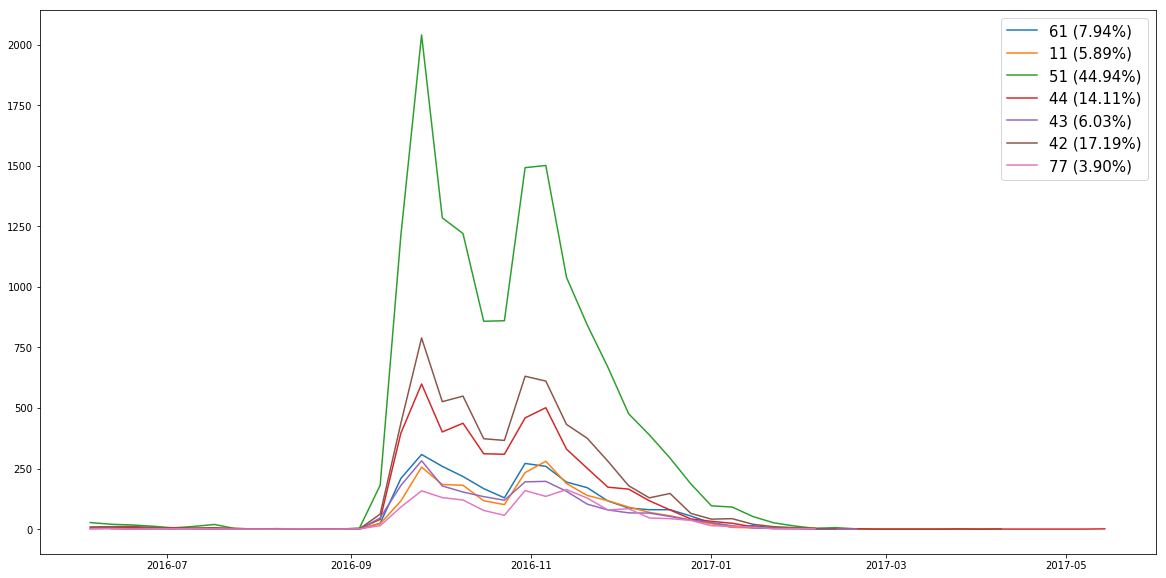

In [20]:
# fig = plt.figure(figsize=(20,10)) 

# start_point = pd.Timestamp(2016,6,1) 
# end_point = pd.Timestamp(2017,5,31)

# vacc = []
# for subdist in contact_matrix_subdist.index:
#     sample_vac_trendline_data = vaccination_data[vaccination_data['subdist'] == subdist].copy()
# #     sample_vac_trendline_data['vac_date'] = pd.to_datetime(sample_vac_trendline_data['vac_date'])
#     sample_vac_trendline_data = sample_vac_trendline_data.groupby('vac_date').count()[['random_ID']]
    
#     vacc = sample_vac_trendline_data[start_point:end_point].resample('W').sum().fillna(0)
# #     vacc = vacc.cumsum() 
# #     vacc = vacc / vacc.random_ID.iloc[-1]
#     plt.plot(vacc, label=f'{int(subdist)} ({vacc_prop_by_stat_area[subdist]*100:.2f}%)')
# plt.legend(fontsize=15)
# plt.show()

In [42]:
# # dates = [pd.Timestamp(2016,6,1) + pd.Timedelta(days=1)*i for i in range(365)]
# model_pred = pd.DataFrame(new_I_sizes[1:], index=dates_2017_short, columns=['newly_infected'])

# mm = model_pred.resample('W').sum().fillna(0)
# fig = plt.figure(figsize=(20, 10)) 
# plt.plot(mm)
# plt.show()


    
#     # Update S effective size (substruct the effective size of the nodes removed from S at this stage)
#     S_eff_sizes.append(S_eff_sizes[-1] - effective_size(new_exposed_t))

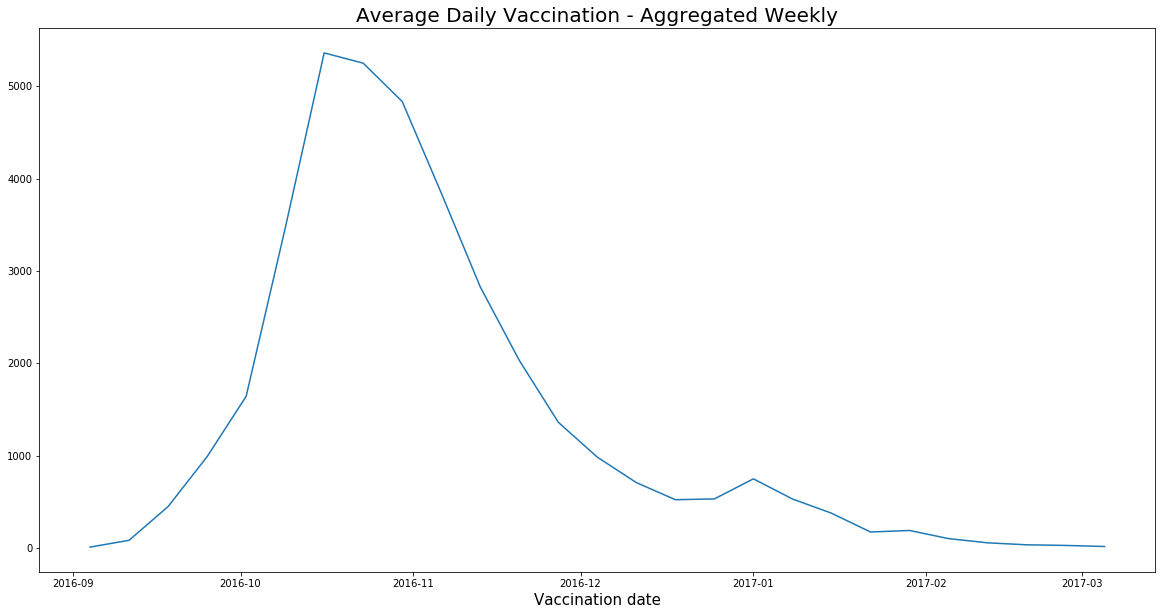

In [13]:
fig = plt.figure(figsize=(20,10)) 
vaccination_data_avg.index = dates_2017_short
vacc = vaccination_data_avg.resample('W').sum().fillna(0)
plt.plot(vacc)

plt.title('Average Daily Vaccination - Aggregated Weekly', size=20)
plt.xlabel('Vaccination date', size=15)

plt.show()